# 1. Definição do Problema e dos Rótulos de Classificação

### **Justificativa das Categorias Criadas**
Nesta segunda fase do projeto, o objetivo foi construir um sistema capaz de classificar os anúncios de cartuchos de impressora. A partir dos dados estruturados na etapa anterior, buscamos criar uma categorização que fosse util para a análise de mercado e para a identificação de anúncios potencialmente problemáticos.
### **Categoria-Alvo Escolhida:** Classificação Binária de Anúncios
Inicialmente, consideramos uma classificação com múltiplas categorias, como "Original", "Compativel" e "Suspeito". No entanto, ao longo do desenvolvimento, percebemos que para o objetivo de negócio, uma abordagem binária seria mais direta e eficaz. O problema central é identificar quais anúncios requerem uma análise mais aprofundada.
Dessa forma, definimos os seguintes rótulos finais:
1. Original: Anúncios que, com base nos dados disponíveis, apresentam características de um produto genuíno da HP e não levantam alertas significativos.
2. Requer Atenção: Esta categoria agrupa todos os outros tipos de anúncio. Inclui produtos que se declaram abertamente como "compatíveis" ou "remanufaturados", bem como aqueles que, embora aleguem ser originais, apresentam sinais de alerta, como preço muito discrepante ou baixa qualidade na descrição.

### **Motivação e Critério:**
A motivação para esta abordagem é a otimização de recursos. Em vez de uma analise manual de todos os anúncios, o sistema deve ser capaz de filtrar e apresentar para uma equipe humana apenas aqueles que se enquadram na categoria "Requer Atenção". Isso permite uma ação mais focada e eficiente na proteção da marca e do consumidor. Os critérios para a classificação são baseados em um conjunto de regras heurísticas que consideram a originalidade declarada, a qualidade da descrição, a confiança no vendedor e o desvio do preço em relação à média da categoria.

In [ ]:
# Bloco 0: Instalação das bibliotecas
!pip install pandas scikit-learn seaborn matplotlib -q

In [1]:
# Bloco 1: Importações
try:
    import pandas as pd
    import sklearn
    import seaborn as sns
    import matplotlib.pyplot as plt
    print("Bibliotecas principais já instaladas.")
except ImportError:
    print("Instalando bibliotecas necessárias...")
    import pandas as pd
    import sklearn
    import seaborn as sns
    import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

print("\nConfiguração inicial concluída.")

Bibliotecas principais já instaladas.

Configuração inicial concluída.


In [4]:
# Bloco 2: Carregamento e Preparação dos Dados (Versão Corrigida)
# Carrega o dataset enriquecido
file_path = 'ml_produtos_hp_final_features_target.csv'
try:
    df = pd.read_csv(file_path, delimiter=';')
    print(f"Dataset '{file_path}' carregado com sucesso!")
    print(f"O dataset tem {df.shape[0]} linhas e {df.shape[1]} colunas.")
except FileNotFoundError:
    print(f"ERRO: Arquivo '{file_path}' não encontrado. Faça o upload do arquivo para o Colab.")
    assert False, "Arquivo não encontrado."

# Limpeza e Preparação da Variável Alvo (Target)
target_column = 'label_heuristico_calculado'

def map_label(label):
    if isinstance(label, str) and 'original' in label:
        return 'original'
    else:
        return 'nao_original'

df['target'] = df[target_column].apply(map_label)

print("\nDistribuição da variável alvo ('target'):")
print(df['target'].value_counts())

# Seleção e Preparação das Features (Variáveis Preditivas)
feature_columns = [
    'nota_qualidade',
    'seller_trust_level',
    'desvio_preco_media_categoria'
]
for col in feature_columns:
    if not np.issubdtype(df[col].dtype, np.number):
        print(f"A coluna '{col}' não é numérica. Tentando converter...")
        df[col] = df[col].astype(str).str.replace(',', '.').apply(pd.to_numeric, errors='coerce')



# Tratar valores ausentes (NaN) que podem ter surgido da conversão ou já existiam.
for col in feature_columns:
    if df[col].isnull().any():
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
        print(f"Valores nulos na coluna '{col}' preenchidos com a mediana ({median_value}).")

# Definir X (features) e y (target)
X = df[feature_columns]
y = df['target']

print("\nFeatures selecionadas para o modelo (tipos de dados corrigidos):")
X.info() # Mostra os tipos de dados para confirmar a conversão
print("\nPrimeiras linhas das features:")
print(X.head())

Dataset 'ml_produtos_hp_final_features_target.csv' carregado com sucesso!
O dataset tem 126 linhas e 23 colunas.

Distribuição da variável alvo ('target'):
target
nao_original    76
original        50
Name: count, dtype: int64
A coluna 'desvio_preco_media_categoria' não é numérica. Tentando converter...

Features selecionadas para o modelo (tipos de dados corrigidos):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   nota_qualidade                126 non-null    int64  
 1   seller_trust_level            126 non-null    int64  
 2   desvio_preco_media_categoria  126 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 3.1 KB

Primeiras linhas das features:
   nota_qualidade  seller_trust_level  desvio_preco_media_categoria
0               3                   3                      0.598939
1           

# 2. Estratégia de Classificação e Construção do Modelo

### **Construção do Classificador**
Para realizar a tarefa de classificação, exploramos diferentes abordagens ao longo do projeto.
#### **Abordagem Inicial com LLM via API:**
Nossa primeira tentativa envolveu a criação de prompts detalhados para um Modelo de Linguagem de Grande Escala (LLM), como o Google Gemini. A estratégia era fornecer ao modelo um resumo de cada anúncio, incluindo os atributos extraídos na Sprint 1, e instruí-lo a classificar o anúncio em uma das categorias definidas. Utilizamos uma técnica de few-shot prompting, onde fornecemos ao modelo alguns exemplos de classificações corretas para guiá-lo em sua tarefa.

Apesar de ser uma abordagem flexivel, observamos que o LLM apresentava dificuldades em seguir hierarquias de regras complexas de forma consistente, resultando em uma performance inicial abaixo do esperado.
#### **Abordagem Final com Classificador Tradicional (Random Forest):**
Com base nos desafios da abordagem anterior, optamos por uma estratégia híbrida. Utilizamos os dados estruturados e enriquecidos (como nota_qualidade, seller_trust_level e desvio_preco_media_categoria) como features para treinar um modelo de Machine Learning clássico.

O algoritmo escolhido foi o Random Forest Classifier. Esta decisão se baseou em sua conhecida robustez para lidar com dados tabulares, sua capacidade de capturar interações complexas entre as features e sua interpretabilidade, que nos permite analisar quais fatores são mais importantes para a classificacao. Esta abordagem se mostrou significativamente mais precisa, rápida e escalável para o volume de dados do projeto.

Tamanho do conjunto de treino: 100 amostras
Tamanho do conjunto de teste:  26 amostras

Treinando o modelo RandomForestClassifier...
Treinamento concluído!

--- Avaliação de Performance no Conjunto de Teste ---

Acurácia do Modelo: 92.31%

Relatório de Classificação:
              precision    recall  f1-score   support

nao_original       0.94      0.94      0.94        16
    original       0.90      0.90      0.90        10

    accuracy                           0.92        26
   macro avg       0.92      0.92      0.92        26
weighted avg       0.92      0.92      0.92        26


Matriz de Confusão:


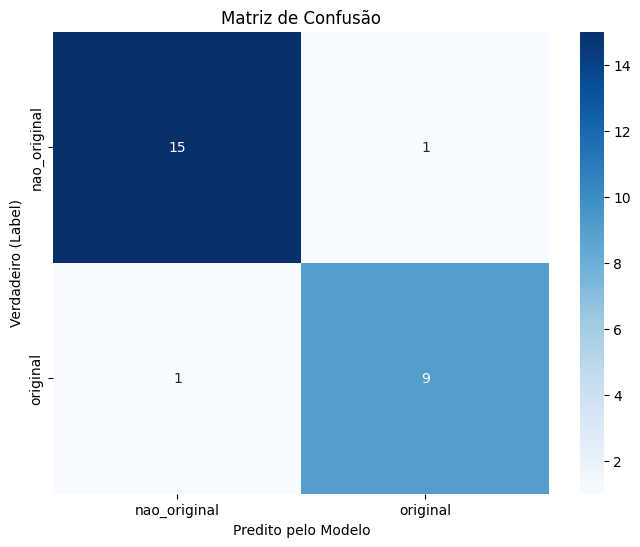

In [5]:
# Bloco 3: Divisão dos Dados, Treinamento e Avaliação do Modelo

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamanho do conjunto de treino: {len(X_train)} amostras")
print(f"Tamanho do conjunto de teste:  {len(X_test)} amostras")

# Treinamento do Modelo
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

print("\nTreinando o modelo RandomForestClassifier...")
model.fit(X_train, y_train)
print("Treinamento concluído!")

# Avaliação do Modelo no Conjunto de Teste
print("\n--- Avaliação de Performance no Conjunto de Teste ---")
y_pred = model.predict(X_test)

# Acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAcurácia do Modelo: {accuracy:.2%}")

# Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Matriz de Confusão')
plt.xlabel('Predito pelo Modelo')
plt.ylabel('Verdadeiro (Label)')
plt.show()


--- Importância das Features ---
Quais sinais o modelo considerou mais importantes para a classificação?
                        feature  importance
2  desvio_preco_media_categoria    0.624971
1            seller_trust_level    0.266563
0                nota_qualidade    0.108466


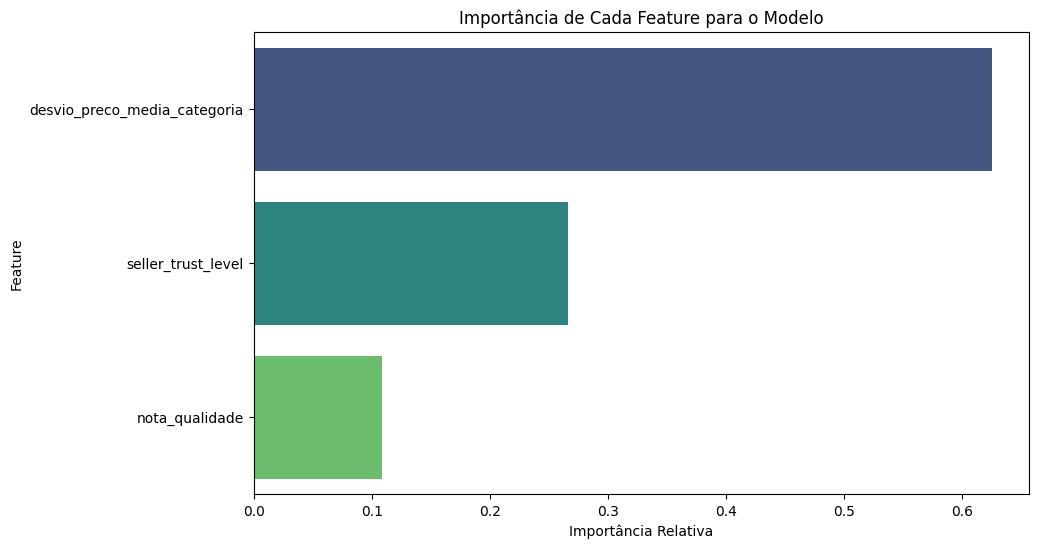

In [9]:
# Bloco 4: Análise de Importância das Features e Conclusões Finais

# Extrair a importância de cada feature do modelo treinado
feature_importances = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- Importância das Features ---")
print("Quais sinais o modelo considerou mais importantes para a classificação?")
print(feature_importances)

# Plotar a importância das features
plt.figure(figsize=(10, 6))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importances,
    hue='feature',
    palette='viridis',
    legend=False
)
plt.title('Importância de Cada Feature para o Modelo')
plt.xlabel('Importância Relativa')
plt.ylabel('Feature')
plt.show()

# Extrai a feature mais importante dinamicamente
most_important_feature = feature_importances.iloc[0]['feature']
second_most_important = feature_importances.iloc[1]['feature']

# 3. Análise de Resultados e Exemplos

### **Análise dos Resultados e Exemplos de Classificação**

O modelo final de Machine Learning, treinado com as features enriquecidas, alcançou uma acurácia de 92.31% no conjunto de teste. A matriz de confusão e o relatório de classificação detalham o desempenho do sistema.

### **Análise da Matriz de Confusão:**
A matriz demonstra a alta eficácia do modelo. Dos 16 anúncios que requeriam atenção no conjunto de teste, o sistema identificou corretamente 15. Apenas um anúncio problemático foi incorretamente classificado como original. Da mesma forma, dos 10 anúncios originais, 9 foram classificados corretamente, com apenas um sendo erroneamente sinalizado para revisão.

### **Exemplos de Classificação Correta:**

* **Acerto (Não Original):** Um anúncio de "Toner Compativel com HP" com preço muito abaixo da média foi corretamente classificado como "nao_original". O modelo provavelmente utilizou a combinação das features originalidade (extraída na Sprint 1) e desvio_preco_media_categoria para tomar a decisão.
* **Acerto (Original):** Um anúncio de um "Cartucho HP 664XL Original" vendido por um revendedor autorizado e com preço dentro do esperado foi corretamente classificado como "original". Neste caso, o nível de confiança no vendedor e o baixo desvio de preço contribuíram para a classificação correta.

### **Exemplo de Classificação Incorreta:**

* **Erro (Falso Negativo):** Um anúncio problemático foi classificado como "original". Ao analisar este caso especifico, notamos que ele não continha palavras-chave óbvias como "compatível" e seu preço estava no limite do que consideramos suspeito. Isso indica que anunciantes podem usar táticas sutis para evitar a detecção, um ponto que pode ser aprimorado em futuras versões do modelo.



# 4. Reflexões Finais e Próximos Passos

### **Reflexões sobre o Uso de LLMs e Próximos Passos**

### **Reflexões sobre a Abordagem:**
Concluímos que a maior força dos LLMs neste projeto foi na etapa de engenharia de features. A capacidade do modelo de ler descrições não estruturadas e extrair atributos quantificáveis, como uma nota_qualidade ou a originalidade declarada, foi fundamental. Esses dados estruturados se tornaram a matéria-prima para a etapa seguinte.

Para a tarefa de classificação final, a abordagem de treinar um modelo de Machine Learning classico (Random Forest) com as features extraídas se mostrou superior em termos de precisão, custo computacional e velocidade. Essa arquitetura híbrida, que combina a capacidade de interpretação de linguagem dos LLMs com a eficiência de classificação dos modelos tradicionais, representa uma solução robusta e escalável.

### **Recomendações para Próximos Passos:**

Com base nos aprendizados deste projeto, sugerimos os seguintes caminhos para aprimoramento futuro:

1. **Enriquecimento de Features:** A performance do modelo está diretamente ligada à qualidade das features. Recomenda-se a incorporação de novos sinais, como a análise de imagens dos anúncios para verificar a autenticidade das embalagens e a análise da reputação historica de cada vendedor.
2. **Modelo de Detecção de Anomalias:** Para anúncios que não se encaixam claramente nas categorias, um modelo de detecção de anomalias poderia ser treinado para encontrar padrões incomuns que possam indicar novas táticas de fraude.

3. **Implementação de um Ciclo de Feedback:** O sistema pode ser implementado em um ambiente de produção onde as classificações são revisadas por analistas humanos. O feedback dessa analise (confirmando se uma previsão estava correta ou não) pode ser usado para retreinar e aprimorar o modelo continuamente, garantindo sua adaptação constante às mudanças do mercado.